In [22]:
import sys
import os

sys.path.insert(0, os.path.dirname(os.path.abspath('.')))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt
import wandb

from modelling.model import TransformerModel
from modelling.scheduler import NoamScheduler, configure_optimizers
from modelling.trainer import Trainer
from data_utils import clean_text_pair, collate_batch
from dataset import TranslationDataset
from tokenizer import GPT2BPETokenizer

In [ ]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
elif torch.backends.mps.is_available():
    DEVICE = 'mps'
else:
    DEVICE = 'cpu'
print(f"Using device: {DEVICE}")


VOCAB_SIZE = 16000
D_MODEL = 256
N_HEADS = 8
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DIM_FEEDFORWARD = 1024
DROPOUT = 0.1
MAX_SEQ_LEN = 128

EPOCHS = 10
BATCH_SIZE = 64
LEARNING_RATE = 1.0
WARMUP_STEPS = 500
GRAD_CLIP = 1.0
WEIGHT_DECAY = 0.01

NUM_TRAIN_SAMPLES = 500000
NUM_VAL_SAMPLES = 20000
NUM_TEST_SAMPLES = 5000
MIN_SEQ_LEN = 5
MAX_SEQ_LEN_FILTER = 50

PAD_IDX = 0
BOS_IDX = 1
EOS_IDX = 2
UNK_IDX = 3

CHECKPOINT_PATH = '../checkpoints/best_model.pt'
TOKENIZER_PATH = '../tokenizer_artifacts'

SEED = 42
torch.manual_seed(SEED)

Using device: mps


In [3]:
print("Loading WMT17 German-English dataset...")
dataset = load_dataset("wmt17", "de-en")
print(f"Dataset loaded: {len(dataset['train'])} train, {len(dataset['validation'])} val, {len(dataset['test'])} test")

def clean_split(data, max_samples, desc="Cleaning"):
    cleaned = []
    for item in tqdm(data, desc=desc):
        if len(cleaned) >= max_samples:
            break
        result = clean_text_pair(
            item['translation']['de'], 
            item['translation']['en'],
            min_len=MIN_SEQ_LEN,
            max_len=MAX_SEQ_LEN_FILTER
        )
        if result:
            cleaned.append(result)
    return cleaned

train_pairs = clean_split(dataset['train'], NUM_TRAIN_SAMPLES, "Cleaning train")
val_pairs = clean_split(dataset['validation'], NUM_VAL_SAMPLES, "Cleaning val")
test_pairs = clean_split(dataset['test'], NUM_TEST_SAMPLES, "Cleaning test")

print(f"\nCleaned data: {len(train_pairs)} train, {len(val_pairs)} val, {len(test_pairs)} test")
print(f"\nExample pair:")
print(f"  DE: {train_pairs[0][0]}")
print(f"  EN: {train_pairs[0][1]}")

Loading WMT17 German-English dataset...


Using the latest cached version of the dataset since wmt17 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'de-en' at /Users/hani/.cache/huggingface/datasets/wmt17/de-en/0.0.0/54d3aacfb5429020b9b85b170a677e4bc92f2449 (last modified on Mon Jan 26 14:47:17 2026).


Dataset loaded: 5906184 train, 2999 val, 3004 test


Cleaning test:  18%|█▊        | 541/3004 [00:00<00:00, 43913.04it/s]


Cleaned data: 50000 train, 2000 val, 500 test

Example pair:
  DE: ich erkläre die am freitag, dem 17. dezember unterbrochene sitzungsperiode des europäischen parlaments für wiederaufgenommen, wünsche ihnen nochmals alles gute zum jahreswechsel und hoffe, daß sie schöne ferien hatten.
  EN: i declare resumed the session of the european parliament adjourned on friday 17 december 1999, and i would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.


In [ ]:
corpus = [pair[0] for pair in train_pairs] + [pair[1] for pair in train_pairs]

tokenizer = GPT2BPETokenizer()
tokenizer.train(corpus, vocab_size=VOCAB_SIZE)

tokenizer.save(TOKENIZER_PATH + ".json")

print(f"Tokenizer trained with vocab size: {tokenizer.get_vocab_size()}")
print(f"Special tokens: PAD={tokenizer.pad_id}, BOS={tokenizer.bos_id}, EOS={tokenizer.eos_id}, UNK={tokenizer.unk_id}")

PAD_IDX = tokenizer.pad_id
BOS_IDX = tokenizer.bos_id
EOS_IDX = tokenizer.eos_id

test_text = "ich liebe dich"
encoded = tokenizer.encode(test_text)
decoded = tokenizer.decode(encoded)
print(f"\nTest: '{test_text}'")
print(f"  Encoded IDs: {encoded}")
print(f"  Decoded: '{decoded}'")




Tokenizer trained with vocab size: 8000
Special tokens: PAD=0, BOS=1, EOS=2, UNK=3

Test: 'ich liebe dich'
  Encoded IDs: [76, 3671, 33, 76]
  Decoded: 'ich liebe d ich'


In [5]:
train_dataset = TranslationDataset(train_pairs, tokenizer, max_len=MAX_SEQ_LEN)
val_dataset = TranslationDataset(val_pairs, tokenizer, max_len=MAX_SEQ_LEN)
test_dataset = TranslationDataset(test_pairs, tokenizer, max_len=MAX_SEQ_LEN)

def custom_collate(batch):
    return collate_batch(batch, pad_idx=PAD_IDX, bos_idx=BOS_IDX, eos_idx=EOS_IDX)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

batch = next(iter(train_loader))
print(f"\nBatch shapes:")
print(f"  src: {batch['src'].shape}")
print(f"  tgt_input: {batch['tgt_input'].shape}")
print(f"  tgt_output: {batch['tgt_output'].shape}")

Train batches: 782, Val batches: 32, Test batches: 8

Batch shapes:
  src: torch.Size([64, 79])
  tgt_input: torch.Size([64, 73])
  tgt_output: torch.Size([64, 73])


In [6]:
model = TransformerModel(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT,
    max_len=MAX_SEQ_LEN,
    use_rope=True
).to(DEVICE)

num_params = sum(p.numel() for p in model.parameters())
print(f"Model created on {DEVICE}")
print(f"Total parameters: {num_params:,}")
print(f"Model size: ~{num_params * 4 / 1024 / 1024:.2f} MB")

Model created on mps
Total parameters: 9,416,512
Model size: ~35.92 MB


In [8]:
optimizer = configure_optimizers(
    model,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    betas=(0.9, 0.98),
    eps=1e-9
)

scheduler = NoamScheduler(
    optimizer,
    d_model=D_MODEL,
    warmup_steps=WARMUP_STEPS
)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    device=DEVICE,
    grad_clip=GRAD_CLIP
)

os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)

print("Training setup complete!")
print(f"  Optimizer: AdamW")
print(f"  Scheduler: Noam (warmup={WARMUP_STEPS})")
print(f"  Loss: CrossEntropyLoss (ignore_index={PAD_IDX})")

Training setup complete!
  Optimizer: AdamW
  Scheduler: Noam (warmup=500)
  Loss: CrossEntropyLoss (ignore_index=0)


In [9]:
trainer.train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    num_epochs=EPOCHS,
    save_path=CHECKPOINT_PATH
)

print("\nTraining complete!")


Epoch 1/20


Epoch 1: 100%|██████████| 782/782 [01:30<00:00,  8.69it/s, loss=5.0198]


Train Loss: 5.7841


Validating: 100%|██████████| 32/32 [00:01<00:00, 20.74it/s]


Val Loss: 6.3373
  ✓ Saved best model (val_loss: 6.3373)
Learning Rate: 0.002234

Epoch 2/20


Epoch 2: 100%|██████████| 782/782 [01:27<00:00,  8.93it/s, loss=4.7624]


Train Loss: 4.9823


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.37it/s]


Val Loss: 6.1908
  ✓ Saved best model (val_loss: 6.1908)
Learning Rate: 0.001580

Epoch 3/20


Epoch 3: 100%|██████████| 782/782 [01:28<00:00,  8.80it/s, loss=4.7746]


Train Loss: 4.7852


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.94it/s]


Val Loss: 6.1214
  ✓ Saved best model (val_loss: 6.1214)
Learning Rate: 0.001290

Epoch 4/20


Epoch 4:  31%|███▏      | 246/782 [00:28<01:00,  8.88it/s, loss=4.7421]Epoch 4: 100%|██████████| 782/782 [01:28<00:00,  8.85it/s, loss=4.7719]


Train Loss: 4.6620


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.95it/s]


Val Loss: 6.0277
  ✓ Saved best model (val_loss: 6.0277)
Learning Rate: 0.001117

Epoch 5/20


Epoch 5: 100%|██████████| 782/782 [01:27<00:00,  8.97it/s, loss=4.5269]


Train Loss: 4.5759


Validating: 100%|██████████| 32/32 [00:01<00:00, 20.76it/s]


Val Loss: 5.9966
  ✓ Saved best model (val_loss: 5.9966)
Learning Rate: 0.000999

Epoch 6/20


Epoch 6: 100%|██████████| 782/782 [01:27<00:00,  8.91it/s, loss=4.4811]


Train Loss: 4.5104


Validating: 100%|██████████| 32/32 [00:01<00:00, 22.08it/s]


Val Loss: 6.0118
Learning Rate: 0.000912

Epoch 7/20


Epoch 7: 100%|██████████| 782/782 [01:28<00:00,  8.87it/s, loss=4.6937]


Train Loss: 4.4477


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.93it/s]


Val Loss: 5.9619
  ✓ Saved best model (val_loss: 5.9619)
Learning Rate: 0.000845

Epoch 8/20


Epoch 8: 100%|██████████| 782/782 [01:27<00:00,  8.93it/s, loss=4.3049]


Train Loss: 4.3939


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.25it/s]


Val Loss: 5.9327
  ✓ Saved best model (val_loss: 5.9327)
Learning Rate: 0.000790

Epoch 9/20


Epoch 9: 100%|██████████| 782/782 [01:27<00:00,  8.91it/s, loss=4.2342]


Train Loss: 4.3437


Validating: 100%|██████████| 32/32 [00:01<00:00, 20.83it/s]


Val Loss: 5.9043
  ✓ Saved best model (val_loss: 5.9043)
Learning Rate: 0.000745

Epoch 10/20


Epoch 10: 100%|██████████| 782/782 [01:27<00:00,  8.98it/s, loss=4.1706]


Train Loss: 4.3009


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.81it/s]


Val Loss: 5.9031
  ✓ Saved best model (val_loss: 5.9031)
Learning Rate: 0.000707

Epoch 11/20


Epoch 11: 100%|██████████| 782/782 [01:27<00:00,  8.92it/s, loss=4.0265]


Train Loss: 4.2590


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.80it/s]


Val Loss: 5.8975
  ✓ Saved best model (val_loss: 5.8975)
Learning Rate: 0.000674

Epoch 12/20


Epoch 12: 100%|██████████| 782/782 [01:27<00:00,  8.94it/s, loss=4.0756]


Train Loss: 4.2154


Validating: 100%|██████████| 32/32 [00:01<00:00, 20.38it/s]


Val Loss: 5.8774
  ✓ Saved best model (val_loss: 5.8774)
Learning Rate: 0.000645

Epoch 13/20


Epoch 13: 100%|██████████| 782/782 [01:27<00:00,  8.89it/s, loss=3.8891]


Train Loss: 4.1784


Validating: 100%|██████████| 32/32 [00:01<00:00, 22.03it/s]


Val Loss: 5.8868
Learning Rate: 0.000620

Epoch 14/20


Epoch 14: 100%|██████████| 782/782 [01:27<00:00,  8.96it/s, loss=4.1295]


Train Loss: 4.1444


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.86it/s]


Val Loss: 5.8493
  ✓ Saved best model (val_loss: 5.8493)
Learning Rate: 0.000597

Epoch 15/20


Epoch 15: 100%|██████████| 782/782 [01:26<00:00,  9.01it/s, loss=3.9399]


Train Loss: 4.1151


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.99it/s]


Val Loss: 5.8356
  ✓ Saved best model (val_loss: 5.8356)
Learning Rate: 0.000577

Epoch 16/20


Epoch 16: 100%|██████████| 782/782 [01:26<00:00,  9.04it/s, loss=4.0448]


Train Loss: 4.0878


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.58it/s]


Val Loss: 5.8346
  ✓ Saved best model (val_loss: 5.8346)
Learning Rate: 0.000559

Epoch 17/20


Epoch 17: 100%|██████████| 782/782 [01:27<00:00,  8.99it/s, loss=3.9999]


Train Loss: 4.0599


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.40it/s]


Val Loss: 5.8183
  ✓ Saved best model (val_loss: 5.8183)
Learning Rate: 0.000542

Epoch 18/20


Epoch 18: 100%|██████████| 782/782 [01:26<00:00,  9.02it/s, loss=3.9028]


Train Loss: 4.0358


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.87it/s]


Val Loss: 5.8287
Learning Rate: 0.000527

Epoch 19/20


Epoch 19: 100%|██████████| 782/782 [01:27<00:00,  8.97it/s, loss=4.2595]


Train Loss: 4.0164


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.05it/s]


Val Loss: 5.8265
Learning Rate: 0.000513

Epoch 20/20


Epoch 20: 100%|██████████| 782/782 [01:26<00:00,  9.00it/s, loss=4.2300]


Train Loss: 3.9985


Validating: 100%|██████████| 32/32 [00:01<00:00, 21.61it/s]

Val Loss: 5.8319
Learning Rate: 0.000500

Training complete!


In [18]:
def translate(model, text, tokenizer, device=DEVICE, max_length=100):
    src_ids = tokenizer.encode(text)
    src = torch.tensor([src_ids], dtype=torch.long, device=device)
    
    generated = model.generate(
        src=src,
        bos_idx=BOS_IDX,
        eos_idx=EOS_IDX,
        max_length=max_length
    )
    
    output_ids = generated[0].tolist()
    
    if EOS_IDX in output_ids:
        output_ids = output_ids[:output_ids.index(EOS_IDX)]
    
    return tokenizer.decode(output_ids, skip_special_tokens=True)

for i in range(10):
    test_sentence = test_pairs[i][0]  # ← [0] statt [i]
    translation = translate(model, test_sentence, tokenizer)
    print(f"  DE: {test_sentence}")
    print(f"  EN (pred): {translation}")
    print(f"  EN (ref):  {test_pairs[i][1]}")  # ← [1] statt [i]
    print("="*70)

  DE: 28-jähriger koch in san francisco mall tot aufgefunden
  EN (pred): i would like to thank the commissioner for his work .
  EN (ref):  28-year-old chef found dead at san francisco mall
  DE: ein 28-jähriger koch, der vor kurzem nach san francisco gezogen ist, wurde im treppenhaus eines örtlichen einkaufzentrums tot aufgefunden.
  EN (pred): the commission has already made a proposal for a regulation for the year 2000 , which is the only way of the european union s financial interests .
  EN (ref):  a 28-year-old chef who had recently moved to san francisco was found dead in the stairwell of a local mall this week.
  DE: der bruder des opfers sagte aus, dass er sich niemanden vorstellen kann, der ihm schaden wollen würde, endlich ging es bei ihm wieder bergauf.
  EN (pred): the commission has already been able to adopt a proposal for a resolution which is not the first time , but it is not a question of the european union .
  EN (ref):  but the victims brother says he cant think o

In [19]:
predictions = []
references = []

model.eval()
for src_text, ref_text in tqdm(test_pairs, desc="Generating translations"):
    pred_text = translate(model, src_text, tokenizer)
    predictions.append(pred_text)
    references.append([ref_text])  # BLEU expects list of references per prediction

bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)

print("\n" + "="*50)
print("BLEU SCORE RESULTS")
print("="*50)
print(f"BLEU Score: {results['bleu']:.4f}")
print(f"Precisions: {[f'{p:.4f}' for p in results['precisions']]}")
print(f"Brevity Penalty: {results['brevity_penalty']:.4f}")
print(f"Length Ratio: {results['length_ratio']:.4f}")

Generating translations: 100%|██████████| 500/500 [02:27<00:00,  3.40it/s]


BLEU SCORE RESULTS
BLEU Score: 0.0026
Precisions: ['0.1517', '0.0093', '0.0004', '0.0001']
Brevity Penalty: 1.0000
Length Ratio: 1.2438


In [20]:
print("Example Translations:")
print("="*70)

num_examples = min(10, len(test_pairs))
for i in range(num_examples):
    src, ref = test_pairs[i]
    pred = predictions[i]
    
    # Calculate individual BLEU
    ind_bleu = bleu.compute(predictions=[pred], references=[[ref]])['bleu']
    
    print(f"\nExample {i+1} (BLEU: {ind_bleu:.4f})")
    print(f"  DE:   {src}")
    print(f"  Pred: {pred}")
    print(f"  Ref:  {ref}")

Example Translations:

Example 1 (BLEU: 0.0000)
  DE:   28-jähriger koch in san francisco mall tot aufgefunden
  Pred: i would like to thank the commissioner for his work .
  Ref:  28-year-old chef found dead at san francisco mall

Example 2 (BLEU: 0.0000)
  DE:   ein 28-jähriger koch, der vor kurzem nach san francisco gezogen ist, wurde im treppenhaus eines örtlichen einkaufzentrums tot aufgefunden.
  Pred: the commission has already made a proposal for a regulation for the year 2000 , which is the only way of the european union s financial interests .
  Ref:  a 28-year-old chef who had recently moved to san francisco was found dead in the stairwell of a local mall this week.

Example 3 (BLEU: 0.0000)
  DE:   der bruder des opfers sagte aus, dass er sich niemanden vorstellen kann, der ihm schaden wollen würde, endlich ging es bei ihm wieder bergauf.
  Pred: the commission has already been able to adopt a proposal for a resolution which is not the first time , but it is not a question 

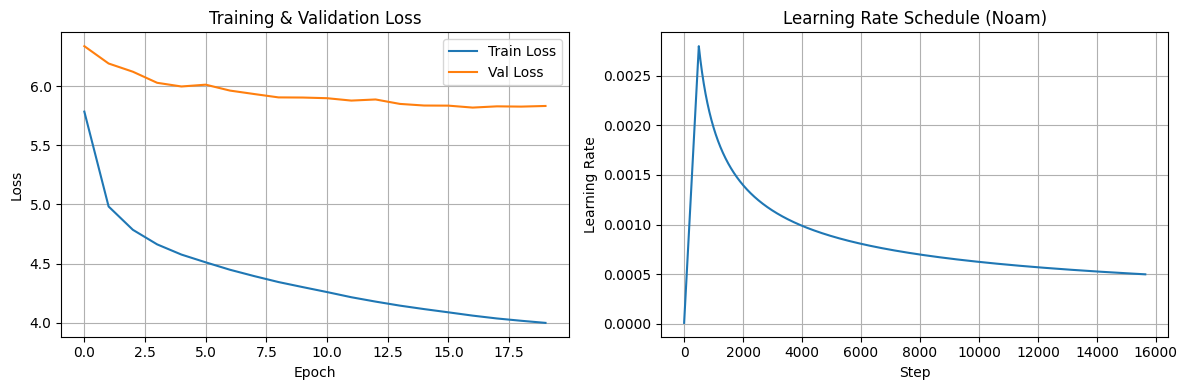


Final Train Loss: 3.9985
Final Val Loss: 5.8319
Best Val Loss: 5.8183


In [21]:
metrics = trainer.get_metrics()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(metrics['train_losses'], label='Train Loss')
axes[0].plot(metrics['val_losses'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True)

if metrics['learning_rates']:
    axes[1].plot(metrics['learning_rates'])
    axes[1].set_xlabel('Step')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Learning Rate Schedule (Noam)')
    axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Train Loss: {metrics['train_losses'][-1]:.4f}")
print(f"Final Val Loss: {metrics['val_losses'][-1]:.4f}")
print(f"Best Val Loss: {min(metrics['val_losses']):.4f}")